# Cellular Neural Network

## Bibliotecas

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from time import time

## Funciones

In [0]:
def CeNN(ent, A, B, I, sal = None, edo = None, radio = (1, 1), frontera = 0,
         tmax = 5, h = 0.01):
    """
    Función que crea una Cellular Nueral Network
    """
    # Obtiene el vecindario
    vecindario = obtieneVecindario(radio)
    
    # Comprueba el tamaño de las plantillas
    tA = np.array(A)
    tB = np.array(B)
    if(vecindario != tA.shape != tB.shape):
        print("Error: Las dimensiones de las plantillas no son validas")
        return 0
    
    # Lee la imagen de entrada
    matEnt = np.array(ent)
    # Se lee la imagen de salida
    if sal == None:
        matSal = np.copy(matEnt)
    else:
        matSal = np.array(sal)
    # Se lee la imagen de estados
    if edo == None:
        matEdo = np.copy(matEnt)
    else:
        matEdo = np.array(edo)
        
    # Comprueba que las dimensiones de las matrices sean las mismas
    if matEnt.shape != matSal.shape != matEdo.shape:
        print("Error las dimensiones son diferentes")
        return 0
        
    # Se agrega la frontera a la imagen de entrada
    matEnt = agregaFrontera(matEnt, frontera = frontera, radio = radio)
    # Se agrega la frontera a la imagen de salida
    matSal = agregaFrontera(matSal, frontera = frontera, radio = radio)
    # Coloca el estado inicial de la red
    matEdo = agregaFrontera(matEdo, frontera = frontera, radio = radio)
    
    # Calcula matriz Iij
    matIij = calcMatIij(matEnt, tB, I, vecindario)
    
    # Inicializa la variable de tiempo
    t = 0
    
    # Comienza con el calculo de la CeNN
    while(t < tmax):
        # Calcula Fij
        matFij = calcMatFij(matSal, tA, vecindario)
        # Calcula matEdo
        matEdo = calcEdo(matEdo, matIij, matFij, h)
        # Calcula matSal
        matSal = satlins(matEdo)
        # Calcula el siguiente paso
        t = t + h
    
    # Elimina las fronteras
    matEnt = eliminaFrontera(matEnt, radio)
    matSal = eliminaFrontera(matSal, radio)
    
    # Regresa las valores
    return [matSal, matEdo, t]

In [0]:
def obtieneVecindario(radio):
    """
    Función que obtiene el tamaño del vecindario de la CeNN,
    calcula a través del radio ingresado
    """
    a = 2*radio[0] + 1
    b = 2*radio[1] + 1
    return (a, b)

In [0]:
def agregaFrontera(ent, frontera = 0, radio = (1, 1)):
    """
    Función que agrega la frontera a la imagen de entrada.
    Entrada:
        ent: matriz de entrada
        tipo: Tipo de frontera. 1. Fijo (Dirichlet), 2. Flujo cero (Neuman), 3. Periodico
              (Toroidal). Se implementará proximamente
        Frontera: Valor de frontera para el tipo Fijo
        radio: Valor del radio y se determina la cantidad de celulas a agregar
    Salida:
        sal: matriz de salida con la frontera agregada
    """
    tam = ent.shape
    x = 2*radio[0] + tam[0]
    y = 2*radio[1] + tam[1]
    sal = np.ones((x, y))*frontera
    sal[radio[0]:x-radio[0], radio[1]:y-radio[1]] = ent
    return sal

In [0]:
def calcMatIij(ent, B, I, vecindario = (3, 3)):
  """
  Parameters
  ----------
  ent : matriz numpy
      matriz de entrada
  B : matriz numpy
      plantillas de filtro
  I : flotante
      valor de bias
      
  Returns
  -------
  matIij: matriz numpy
      matriz de numpy que contiene el valor Iij
  """
  matIij = np.copy(ent)
  dim = matIij.shape
  for i in range(int(dim[0] - (vecindario[0] - 1)/2) - 1):
    for j in range(int(dim[1] - (vecindario[1] - 1)/2) - 1):
      x0 = i
      x1 = x0 + vecindario[0]
      y0 = j
      y1 = y0 + vecindario[1]
      temp = ent[int(x0): int(x1), int(y0): int(y1)]
      x0 = int((vecindario[0] - 1)/2)
      y0 = int((vecindario[1] - 1)/2)
      matIij[i + x0, j + y0] = np.tensordot(temp, B) + I
  return matIij

In [0]:
def calcMatFij(ent, A, vecindario = (3, 3)):
  """
  Parameters
  ----------
  ent : TYPE
      DESCRIPTION. Matriz numpy de entrada
  A : TYPE
      DESCRIPTION. Plantilla de salida de la CeNN
  vecindario : TYPE, optional
      DESCRIPTION. The default is (3, 3).

  Returns
  -------
  matFij: Matriz numpy
      DESCRIPTION: El resultado de la convolución de A en ent
  """
  matFij = np.copy(ent)
  dim = ent.shape
  for i in range(int(dim[0] - (vecindario[0] - 1)/2) - 1):
    for j in range(int(dim[1] - (vecindario[1] - 1)/2) - 1):
      x0 = i
      x1 = x0 + vecindario[0]
      y0 = j
      y1 = y0 + vecindario[1]
      temp = ent[int(x0): int(x1), int(y0): int(y1)]
      x0 = int((vecindario[0] - 1)/2)
      y0 = int((vecindario[1] - 1)/2)
      matFij[i + x0, j + y0] = np.tensordot(temp, A)
  return matFij

In [0]:
def calcEdo(matEdo, matIij, matFij, h = 0.1):
  """
  Parameters
  ----------
  matEdo : matriz numpy
      Matriz de estados
  matIij : matriz numpy
      Matriz Iij
  matFij : matriz numpy
      Matriz Fij
  h : TYPE, optional
      DESCRIPTION. The default is 0.1.

  Returns
  -------
  matEdos : matriz numpy
      Matriz de estados actualizada
  """
  matEdos = np.copy(matEdo)
  dim = matEdos.shape
  for i in range(dim[0]):
    for j in range(dim[1]):
      matEdos[i,j] = matEdo[i,j] + h*(matFij[i,j] + matIij[i,j] - matEdo[i,j])
  return matEdos

In [0]:
def satlins(ent):
  """
  Parameters
  ----------
  ent : Matriz numpy
      Matriz de entrada
      
  Returns
  -------
  sal : Matriz numpy
      Matriz de salida
  """
  sal = np.copy(ent)
  dim = sal.shape
  for i in range(dim[0]):
    for j in range(dim[1]):
      sal[i,j] = 0.5*(np.abs(ent[i,j] + 1) - np.abs(ent[i,j] - 1))
  return sal

In [0]:
def eliminaFrontera(ent, radio):
  """
  Parameters
  ----------
  ent : matriz de numpy
      Matriz de entrada a la cual se le quitara la frontera
  radio : entero
      Cantidad de filas, columnas y/o profundidad a ser eliminadas
      
  Returns
  -------
  sal : matriz de numpy sin la frontera
  """
  tam = ent.shape
  sal = ent[radio[0]:tam[0]-radio[0], radio[1]:tam[1]-radio[1]]
  return sal

# Prueba

## Carga de imagen

In [32]:
# ----- Leer las matrices CeNN ----- #
# Lee las imagenes de entrenamiento
imgEntLena = Image.open("./Imagenes/lena.png")
imgEntLena = imgEntLena.convert('L')
imgEntLena = np.array(imgEntLena)

imgEntGrises = Image.open("./Imagenes/Grises0_120x120_paso4.png")
imgEntGrises = imgEntGrises.convert('L')
imgEntGrises = np.array(imgEntGrises)

print("Dimensiones de la imagen de Lena: {}".format(imgEntLena.shape))
print("Dimensiones de la imagen de grises: {}".format(imgEntGrises.shape))

Dimensiones de la imagen de Lena: (384, 384)
Dimensiones de la imagen de grises: (120, 120)


## Ejecuta CeNN

In [34]:
# Tiempos
h = 0.03125
tmax = 1.0
# Plantillas
A = np.array([[2.35406331, -9.86198524, -4.12561655],
              [-10.46921506, 60.8963263, -10.46921506],
              [-4.12561655, -9.86198524, 2.35406331]])
B = np.array([[-7.3327797, -10.36892724, -2.14952112],
              [-20.72864443, 62.47862202, -20.72864443],
              [-2.14952112, -10.36892724, -7.3327797 ]])
I = -12.213750244021483

# Convierte a valores CeNN
imgCeNNLenaEnt = 1.-(2.*imgEntLena)/255.
imgCeNNGrisesEnt = 1.-(2.*imgEntGrises)/255.

# ----- Ejecuta la Red Neuronal Celular ----- #
# Imagen de Lena
imgSal = CeNN(imgCeNNLenaEnt, A, B, I, tmax = tmax, h = h)
imgSal = imgSal[0]
# Convierte a valores entre 0 y 255
imgSalLena = 0.5 * (255. * (1. - imgSal))
imgSalLena = imgSalLena.astype(int)
print("He terminado de simular Lena")

# Imagen de Grises
imgSal = CeNN(imgCeNNGrisesEnt, A, B, I, tmax = tmax, h = h)
imgSal = imgSal[0]
# Convierte a valores entre 0 y 255
imgSalGrises = 0.5 * (255. * (1. - imgSal))
imgSalGrises = imgSalGrises.astype(int)
print("He terminado de simular Grises")

# Mensaje de Finalizado
print("He terminado de simular la CeNN")

He terminado de simular Lena
He terminado de simular Grises
He terminado de simular la CeNN


## Muestra el resultado

(-0.5, 119.5, 119.5, -0.5)

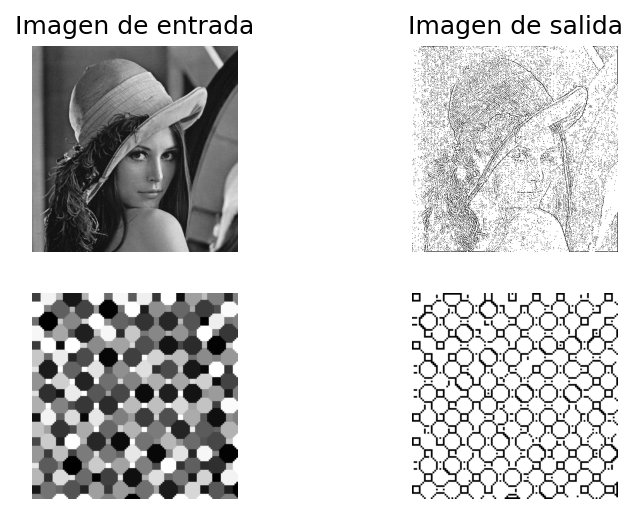

In [36]:
# Muestra el resultado
fig,axes = plt.subplots(nrows = 2, ncols = 2, dpi = 150)
axes[0,0].imshow(imgEntLena, cmap = 'gray')
axes[0,0].set_title("Imagen de entrada")
axes[0,0].axis('off')
axes[0,1].imshow(imgSalLena, cmap = 'gray')
axes[0,1].set_title("Imagen de salida")
axes[0,1].axis('off')
axes[1,0].imshow(imgEntGrises, cmap = 'gray')
axes[1,0].axis('off')
axes[1,1].imshow(imgSalGrises, cmap = 'gray')
axes[1,1].axis('off')